In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# # 데이터 경로 변수
# ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
# TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
# VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
# TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


from pathlib import Path
directory = Path.joinpath(Path.cwd(),'data')

TRAIN_PATH = Path.joinpath(directory, 'train','*','*')
TEST_PATH  = Path.joinpath(directory, 'test','*','*')
VAL_PATH   = Path.joinpath(directory, 'val','*','*')
TRAIN_PATH = str(TRAIN_PATH)
TEST_PATH  = str(TEST_PATH)
VAL_PATH   = str(VAL_PATH)

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 64
EPOCHS = 20

print(TRAIN_PATH)


/aiffel/aiffel/chest_xray/data/train/*/*


#### 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames  = tf.io.gfile.glob(TEST_PATH)
val_filenames   = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))


# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH)) # val_data 없이 한번에 불러들임

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames   = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

5216
624
16
4185
1047


In [4]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=1) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    pic_size = np.multiply(np.array(IMAGE_SIZE),[1.8,1.5])
    pic_size[0] = int(np.rint(pic_size[0]))
    pic_size[1] = int(np.rint(pic_size[1]))
    img = tf.image.resize(img, pic_size, antialias=True)
    offset_height = int(np.rint(0.4*IMAGE_SIZE[0]))
    offset_width  = int(np.rint(0.25*IMAGE_SIZE[1]))
    img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, IMAGE_SIZE[0], IMAGE_SIZE[1])
    img = tf.image.per_image_standardization(img)
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img   = tf.io.read_file(file_path) # 이미지 읽기
    img   = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds   =   val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 1)
Label:  False


In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

#### 3. 데이터 시각화

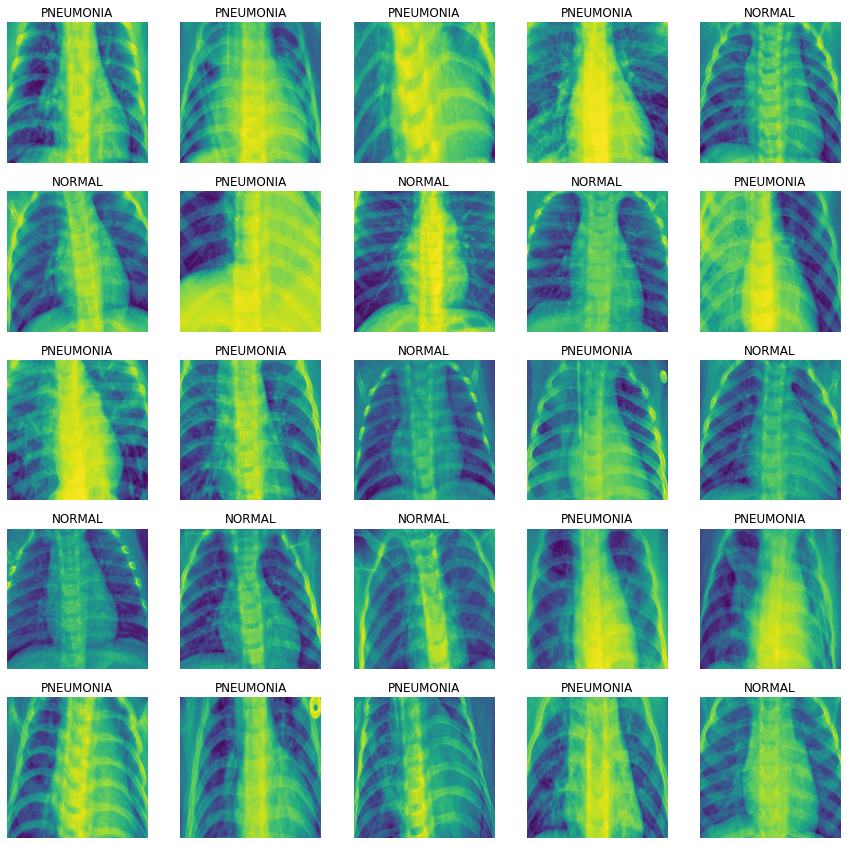

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
show_batch(image_batch.numpy(), label_batch.numpy())     

#### 4. CNN 모델링

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 5. 데이터 imbalance 처리

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


#### 6. 모델 훈련

In [19]:
from tensorflow import keras

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.005),
        loss='binary_crossentropy',
        metrics=METRICS
    )  

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight        
    )

Epoch 1/20
65/65 [==============================] - 53s 620ms/step - loss: 0.3729 - accuracy: 0.8185 - precision: 0.9577 - recall: 0.7908 - val_loss: 2.5849 - val_accuracy: 0.2646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
65/65 [==============================] - 41s 639ms/step - loss: 0.2130 - accuracy: 0.9147 - precision: 0.9757 - recall: 0.9080 - val_loss: 2.6772 - val_accuracy: 0.2666 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
65/65 [==============================] - 43s 662ms/step - loss: 0.1996 - accuracy: 0.9228 - precision: 0.9727 - recall: 0.9222 - val_loss: 3.0378 - val_accuracy: 0.2637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
65/65 [==============================] - 45s 706ms/step - loss: 0.1640 - accuracy: 0.9329 - precision: 0.9805 - recall: 0.9281 - val_loss: 8.0641 - val_accuracy: 0.2637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
65/65 [==============================] - 41s 629ms/step -

#### 7. 결과 확인

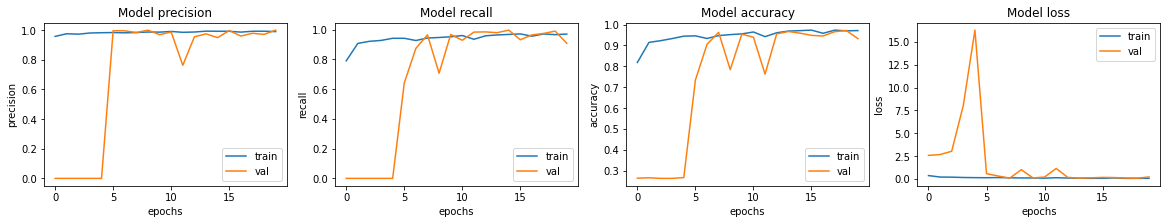

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 397ms/step - loss: 0.3335 - accuracy: 0.8958 - precision: 0.9093 - recall: 0.9256
Loss: 0.3335224688053131,
Accuracy: 0.8958333134651184,
Precision: 0.9093198776245117,
Recall: 0.9256410002708435


#### 8. 미세조정

In [28]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [29]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0025, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=100,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,    
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
    )

Epoch 1/100
65/65 [==============================] - 47s 633ms/step - loss: 0.0148 - accuracy: 0.9952 - precision: 0.9990 - recall: 0.9945 - val_loss: 0.1169 - val_accuracy: 0.9648 - val_precision: 0.9601 - val_recall: 0.9933
Epoch 2/100
65/65 [==============================] - 40s 621ms/step - loss: 0.0349 - accuracy: 0.9870 - precision: 0.9961 - recall: 0.9864 - val_loss: 0.1725 - val_accuracy: 0.9502 - val_precision: 0.9422 - val_recall: 0.9934
Epoch 3/100
65/65 [==============================] - 41s 641ms/step - loss: 0.0240 - accuracy: 0.9901 - precision: 0.9974 - recall: 0.9893 - val_loss: 0.1512 - val_accuracy: 0.9619 - val_precision: 0.9529 - val_recall: 0.9973
Epoch 4/100
65/65 [==============================] - 44s 675ms/step - loss: 0.0217 - accuracy: 0.9916 - precision: 0.9971 - recall: 0.9916 - val_loss: 0.0884 - val_accuracy: 0.9814 - val_precision: 0.9830 - val_recall: 0.9921
Epoch 5/100
65/65 [==============================] - 46s 708ms/step - loss: 0.0196 - accuracy: 0

#### 9. 미세조정 결과 확인

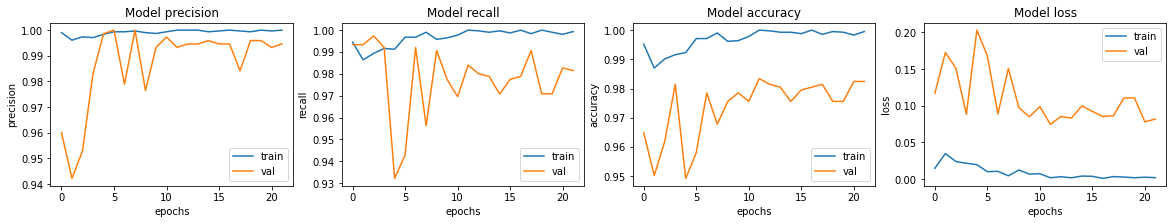

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 335ms/step - loss: 1.3274 - accuracy: 0.8317 - precision: 0.7914 - recall: 0.9923
Loss: 1.3274073600769043,
Accuracy: 0.8317307829856873,
Precision: 0.7914110422134399,
Recall: 0.9923076629638672


### 후 기

데이터 사진은 축소 크롭 정규화 과정을 거쳤다. 이는 신체에서 폐렴을 검진하는 부분은 기관지 분기 부분이라 비교적 신체중앙에 위치해서 사진 가운데를 집중적으로 확대해서 볼 수 있게 준비 한 것이다. 신체의 특성에 따라 사진의 노출 정도가 달라지므로 -1~1 사이에 데이터가 분포하도록 정규화 시켰다. 이런 준비과정을 거치자 정확도가 80% 에서 90%로 올랐다.

그러나 미세조정 후 검증셋의 정확도가 98%에 이르는데도 불구하고 트레이닝셋과 같은 전처리 과정을 거친 테스트셋의 정확도는 83% 밖에 나오지 않는 것을 보면 데이터 준비에 오류가 있었던지 가상의 환자 데이터가 만들어졌던지 데이터가 오염이 된 것같다. 교육용 폐렴 환자사진을 보면 같은 장신구를 착용한 환자(?)의 사진이 자세가 다르거나 위치가 변경되면서 여러장 발견되는 등 페이크 자료로 의심할만한 증거가 여럿 발견되었다.

배치크기나 다른 변수들을 계속 변경시켜봤지만 눈에 띄는 성능 증가는 없었다. 



